# Classifying Humorous Text from Yelp Reviews

In [44]:
# !!! Note for Group: takes my machine about 40 to run this notebook.
# You may want to run it on Colab or download 
# https://drive.google.com/file/d/11WdZeVN-hc-HmODwFiNHgeZse_v3yxNH/view?usp=sharing 
# for csv of approx 840k+ texts ('review') with labels ('humor') instead.

In [31]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from etl_humor import *

## Load & Clean Data

##### Download dataset from https://www.kaggle.com/yelp-dataset/yelp-dataset

In [32]:
review_df = df_from_json("./data/yelp_academic_dataset_review.json")
business_df = df_from_json("./data/yelp_academic_dataset_business.json")

In [33]:
# Clean review text and add word count column to review df
review_df = review_df[['user_id', 'business_id', 'stars', 'useful', 'funny','text']]
review_df['text'] = review_df['text'].apply(format_review)
review_df['word_count'] = review_df['text'].apply(word_count)

In [34]:
# Select columns in business df and rename stars to avg_stars for business stars
business_df = business_df[['business_id', 'name', 'city', 'state', 'stars', 'review_count', 'is_open', 'attributes', 'categories']]
business_df.columns = ['business_id', 'name', 'city', 'state', 'avg_stars', 'review_count','is_open', 'attributes','categories']
business_df = business_df[business_df['name'].notna()]

In [35]:
# merge reviews with business df to get name, etc.
merged_data_large = pd.merge(business_df, review_df, on="business_id", how = "left")

In [36]:
# Concatenate the name of the business and the text together (some humor is based on the business name)
merged_data_large['review'] = merged_data_large.name + '. ' + merged_data_large.text

In [37]:
# Select columns for final df
final_df_large = merged_data_large[['business_id', 'categories', 'user_id', 'funny', 'review', 'word_count']]

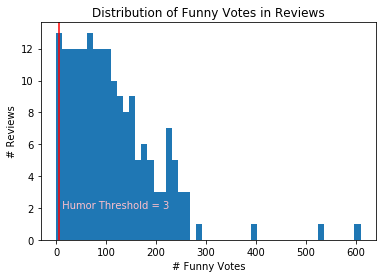

In [38]:
# We will consider a review as humorous if it has 3 or more funny votes and not humorous if it has 0 funny votes. 
# Plot distribution of funny votes.

humor_threshold = 3

humor_pt = final_df_large.pivot_table('user_id', ['funny'], aggfunc='count').reset_index()
funny_votes = humor_pt.funny.values

plt.hist(funny_votes, bins=50, density = False)  # density=False would make counts
plt.axvline(x=5, color = 'red')
plt.text(5, 2, ' Humor Threshold = 3', color = 'pink')
plt.ylabel('# Reviews')
plt.xlabel('# Funny Votes')
plt.title('Distribution of Funny Votes in Reviews')
plt.show()

In [39]:
# Determine how many text we have considered not humorous, humorous, and those that dont make the humor threshold
def f(row):
    if row['funny'] >= humor_threshold:
        val = 1
    elif row['funny'] == 0:
        val = 0
    else:
        val = 'NaN'
    return val

final_df_large['humor'] = final_df_large.apply(f, axis=1)

final_df_large = final_df_large[final_df_large['humor'].notna()]
final_df_large = final_df_large[final_df_large['review'].notna()]

humor_label_pt = final_df_large.pivot_table('review', ['humor'], aggfunc='count').reset_index()
print(humor_label_pt)

/opt/anaconda3/envs/USGS_1/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


  humor   review
0     0  7038968
1     1   340864
2   NaN  1255571


In [40]:
# Select all humorous and 500k not humorous (plain) texts to create more balanced train/test sets.
plain_text = final_df_large[final_df_large.humor == 0]
plain_text = plain_text.sample(n = 500000)
humor_text = final_df_large[final_df_large.humor == 1]

In [41]:
result = pd.concat([plain_text, humor_text])

In [43]:
result.to_csv("./data/yelp_humor_merged.csv", index=False)

## Split into training and testing sets

In [42]:
labels = list(result.humor.values)
reviews = list(result.review.values)

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0, stratify=labels)